In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных

In [110]:
df = pd.read_csv(r"C:\Users\mnikolyuk001\Downloads\CAC40_240118_240119 (1).txt", delimiter = ",")

In [111]:
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,CAC40,D,02/01/23,0,6473.76,6601.11,6473.76,6594.57,2020
1,CAC40,D,03/01/23,0,6594.57,6696.10,6580.09,6623.89,2030
2,CAC40,D,04/01/23,0,6623.89,6780.83,6623.89,6776.43,2026
3,CAC40,D,05/01/23,0,6776.43,6792.09,6732.04,6761.50,2017
4,CAC40,D,06/01/23,0,6761.50,6860.95,6757.46,6860.95,2016


In [112]:
df['date'] = pd.to_datetime(df['<DATE>'], dayfirst = True)

C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/1838240893.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['<DATE>'], dayfirst = True)


In [145]:
def ema(df, N, col):
    df['ema_{}_{}'.format(col, N)] = 0
    df['ema_{}_{}'.format(col, N)][0] = df[col][0]
    A = 2/(1+N)
    for i in range(1,df.shape[0]):
        df['ema_{}_{}'.format(col, N)][i] = df[col][i]*A + df['ema_{}_{}'.format(col, N)][i-1] * (1-A)
    return df

def ma(df, N, col):
    df['ma_{}_{}'.format(col, N)] = 0
    df['ma_{}_{}'.format(col, N)][0:N] = df['<CLOSE>'][0:N]
    for i in range(N,df.shape[0]):
        df['ma_{}_{}'.format(col, N)][i] = df['<CLOSE>'][i-N+1:i+1].mean()
    return df


def smm(df, N):
    df['smm_{}'.format(N)] = 0
    df['smm_{}'.format(N)][0:N] = df['<CLOSE>'][0:N]
    for i in range(N,df.shape[0]):
        df['smm_{}'.format(N)][i] = df['<CLOSE>'][i-N+1:i+1].median()
    return df

## Money flow multiplier (MFM)

In [114]:
df['mfm'] = ((df['<CLOSE>']-df['<LOW>'])-(df['<HIGH>']-df['<CLOSE>']))/(df['<HIGH>']-df['<LOW>'])
df.loc[(df['<HIGH>']-df['<LOW>']) == 0, 'mfm'] = 0

## Money Flow Volume (MFV)

In [115]:
df['mfv'] = df['mfm']*df['<VOL>']

## Индикатор Накопление/Распродажа (Accumulation/Distribution) 

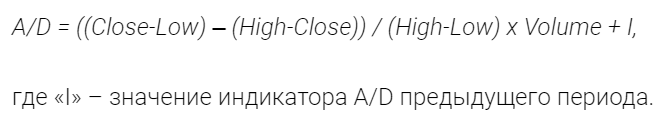

In [116]:
def a_d(df):
    df['a_d'] = 0
    df['a_d'][0] = df['mfv'][0]
    for i in range(1,df.shape[0]):
        df['a_d'][i] = df['a_d'][i-1] + df['mfv'][i]
    return df

In [117]:
df = a_d(df)

C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/524345320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['a_d'][0] = df['mfv'][0]


## Accumulation Destribution Line (ADL)

In [118]:
def adl(df):
    df['adl'] = 0
    df['adl'][0] = df['mfv'][0]
    for i in range(1,df.shape[0]):
        df['adl'][i] = df['mfv'][i-1] + df['mfv'][i]
    return df

In [119]:
df = adl(df)

C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/3699770297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adl'][0] = df['mfv'][0]


## Chaikin oscillator

In [120]:
def CO(df, per_1, per_2):
    df = ema(df, per_1, 'adl')
    df = ema(df, per_2, 'adl')
    df['OC'] = df['ema_{}_{}'.format('adl', per_2)]-df['ema_{}_{}'.format('adl', per_1)]
    return df

In [121]:
df = CO(df, 3, 10)

C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/266659360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ema_{}_{}'.format(col, N)][0] = df[col][0]
C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/266659360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ema_{}_{}'.format(col, N)][0] = df[col][0]


In [147]:
import matplotlib.pyplot as plt

def plot_OC(df, val_col, OC_col):
    fig, ax1 = plt.subplots(figsize=(18,10))

    color = 'tab:red'
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Цена', color=color)
    ax1.plot(df['date'], df[val_col], color = 'green')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Осцилятор Чайкина', color='blue')
    ax2.plot(df['date'], df[OC_col], marker='.', linestyle='--')
    ax2.axhline(y=0, linestyle='-' , color='red')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.show()



In [158]:
df = ma(df, 2, '<CLOSE>')

C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/1399549738.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ma_{}_{}'.format(col, N)][0:N] = df['<CLOSE>'][0:N]


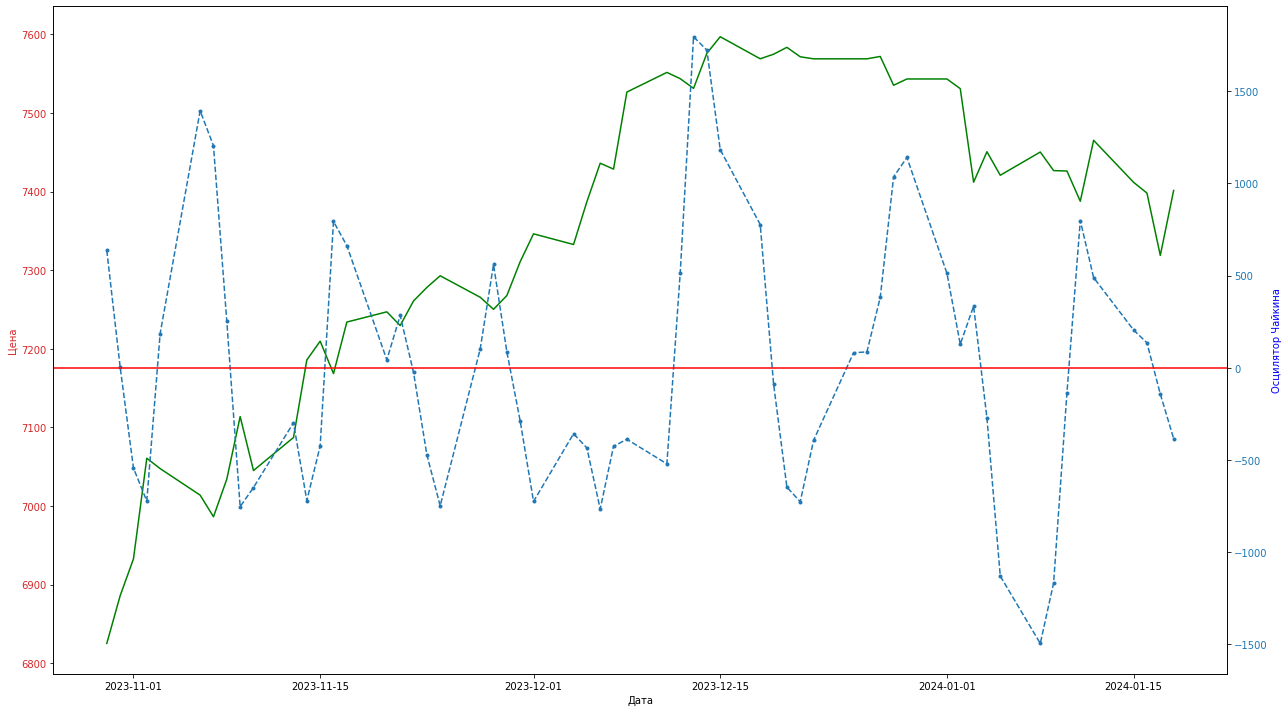

In [191]:
plot_OC(df.iloc[-60:-1], '<CLOSE>', 'OC')

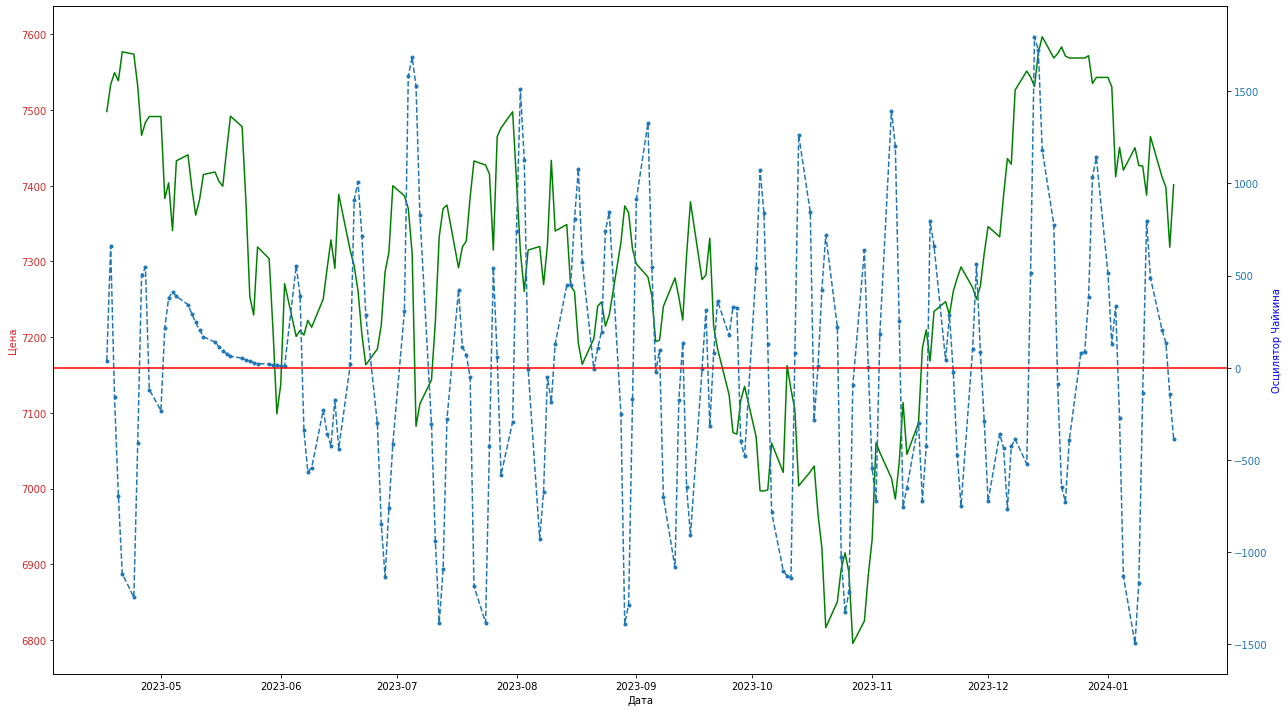

In [163]:
plot_OC(df.iloc[-200:-1], '<CLOSE>', 'OC')

## Принятие решения

In [208]:
def decision_OC(df):
    df['action'] = 0
    df['decision'] = 0
    j = 0
    for i in range(1, df.shape[0]):
        if (df['OC'][i]>0 and df['OC'][i-1]<0) or (df['OC'][i]<0 and df['OC'][i-1]>0):
            df['action'][i] = 1
#             print(i, j)
            if df['<CLOSE>'][i]>df['<CLOSE>'][j]:
                df['decision'][i] = 1
            elif df['<CLOSE>'][i]<df['<CLOSE>'][j]:
                df['decision'][i] = -1
            else:
                df['decision'][i] = 0
            j = i
    return df

In [209]:
df = decision_OC(df)

C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/2150810105.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action'][i] = 1
C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/2150810105.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decision'][i] = 1
C:\Users\MNIKOL~1\AppData\Local\Temp/ipykernel_22236/2150810105.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['action'][i] = 1
C:\Users\MNIKOL~1\AppData\Lo

In [211]:
df.loc[df['action']==1]

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,date,...,OC,ma_10,ma_30,ma_OC_30,ma_OC_5,ma_OC_2,ma_OC_1,ma_<CLOSE>_2,action,decision
4,CAC40,D,06/01/23,0,6761.50,6860.95,6757.46,6860.95,2016,2023-01-06,...,-76.062266,6860.950,6860.950000,6860.950000,6860.950,6811.225,6860.95,6811.225,1,1
6,CAC40,D,10/01/23,0,6907.36,6907.36,6845.81,6869.14,2026,2023-01-10,...,285.745015,6869.140,6869.140000,6869.140000,6835.076,6888.250,6869.14,6888.250,1,1
10,CAC40,D,16/01/23,0,7023.50,7052.52,7016.32,7043.31,2015,2023-01-16,...,-164.485255,6876.595,7043.310000,7043.310000,6967.164,7033.405,7043.31,7033.405,1,1
12,CAC40,D,18/01/23,0,7077.16,7115.20,7072.45,7083.39,2029,2023-01-18,...,530.880724,6952.618,7083.390000,7083.390000,7040.608,7080.275,7083.39,7080.275,1,1
16,CAC40,D,24/01/23,0,7032.02,7064.69,7011.40,7050.48,1992,2023-01-24,...,-440.753073,7015.759,7050.480000,7050.480000,7022.750,7041.250,7050.48,7041.250,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,CAC40,D,19/12/23,0,7568.86,7579.86,7553.08,7574.67,2023,2023-12-19,...,-87.581548,7533.365,7329.292333,7329.292333,7569.502,7571.765,7574.67,7571.765,1,1
255,CAC40,D,25/12/23,0,7568.82,7568.82,7568.82,7568.82,0,2023-12-25,...,81.698296,7568.353,7396.377333,7396.377333,7573.428,7568.820,7568.82,7568.820,1,-1
263,CAC40,D,04/01/24,0,7411.86,7455.37,7410.18,7450.63,2019,2024-01-04,...,-272.006231,7529.315,7474.473000,7474.473000,7495.942,7431.245,7450.63,7431.245,1,-1
268,CAC40,D,11/01/24,0,7426.08,7479.42,7382.88,7387.62,2025,2024-01-11,...,798.782340,7459.096,7498.620333,7498.620333,7422.250,7406.850,7387.62,7406.850,1,-1


In [237]:
def decision_OC_div(df, N, trend):
    if trend == 'upper':
        df_OC = df['OC'].nlargest(2).reset_index()
        if df_OC['index'][0]<df_OC['index'][1] and df['<CLOSE>'][df_OC['index'].max()]>df['<CLOSE>'][df_OC['index'].min()]:
            print('Продаем при пересечении OC и 0')
    elif trend == 'down':
        df_OC = df['OC'].nsmallest(2).reset_index()
        if df_OC['index'][0]<df_OC['index'][1] and df['<CLOSE>'][df_OC['index'].max()]<df['<CLOSE>'][df_OC['index'].min()]:
            print('Покупаем при пересечении OC и 0')
    else: print('Не стоит предпринимать действий')
    plot_OC(df.iloc[-N:-1], '<CLOSE>', 'OC')

Продаем при пересечении OC и 0


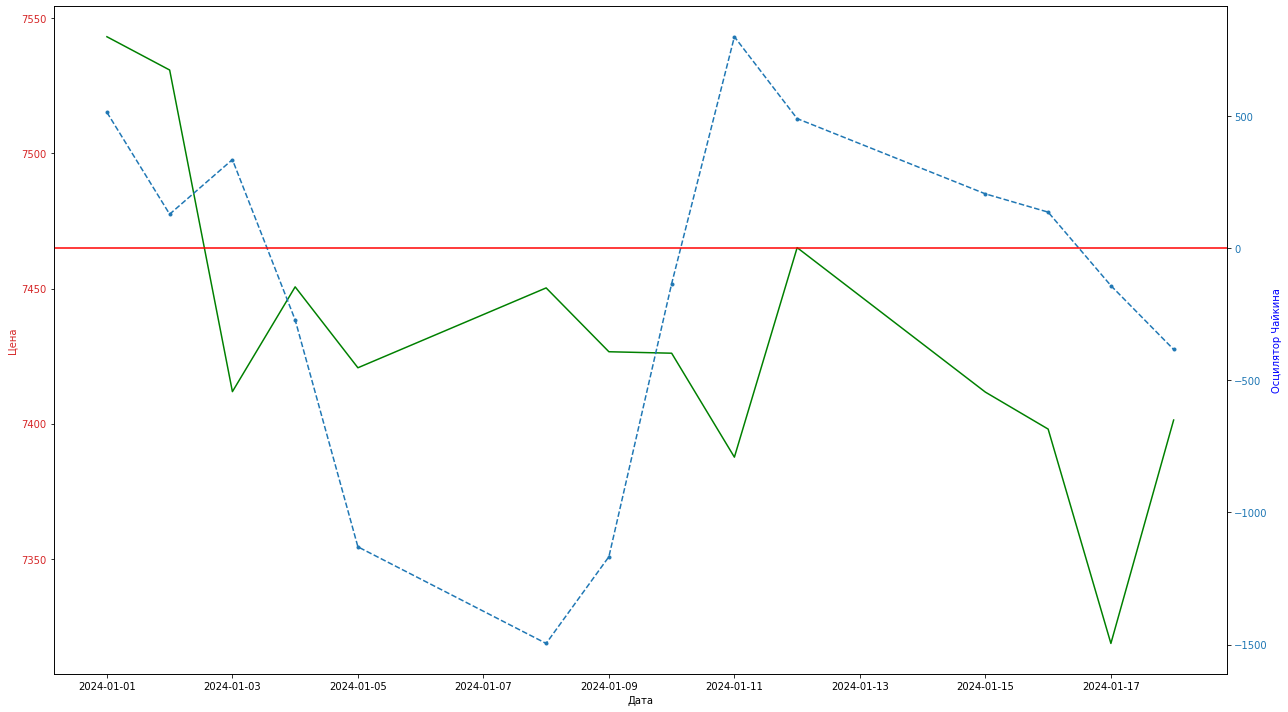

In [240]:
decision_OC_div(df, 15, 'upper')